# EUR/USD Forecasting — LSTM (Executable Notebook)
Data prep → LSTM training → Metrics (MAE/RMSE/MAPE/DA) → DM vs naïve → SHAP → Exports.

In [ ]:
# Environment setup (Colab friendly)
import sys
import subprocess
import pkgutil

REQUIRED_PACKAGES = {
    "tensorflow": "tensorflow==2.16.1",
    "numpy": "numpy==1.26.4",
    "pandas": "pandas==2.2.3",
    "matplotlib": "matplotlib==3.10.0",
    "scikit-learn": "scikit-learn==1.5.1",
    "shap": "shap==0.45.0",
}

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False


def ensure(package_spec: str):
    pkg_name = package_spec.split("==")[0]
    if pkgutil.find_loader(pkg_name) is None:
        print(f"Installing {package_spec} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_spec])
    else:
        try:
            import importlib
            mod = importlib.import_module(pkg_name)
            if hasattr(mod, "__version__"):
                ver = mod.__version__
                if "==" in package_spec and ver != package_spec.split("==")[1]:
                    print(f"Updating {package_spec} (current {ver}) ...")
                    subprocess.check_call([sys.executable, "-m", "pip", "install", package_spec])
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_spec])

if IN_COLAB:
    print("Detected Google Colab runtime. Installing required packages (GPU support enabled if runtime->GPU).")
    for spec in REQUIRED_PACKAGES.values():
        ensure(spec)
else:
    print("Local runtime detected. Ensure the following packages are available:")
    for spec in REQUIRED_PACKAGES.values():
        print(" -", spec)


In [2]:
# Parameters
SYMBOL   = "EURUSD=X"
START    = "2005-01-01"
END      = "2025-06-30"
LOOKBACK = 60
HORIZON  = 1

SPLIT_TRAIN_END = "2022-12-31"
SPLIT_VAL_END   = "2023-12-31"

EPOCHS = 120
BATCH  = 32
RANDOM_SEED = 42
RUN_TRAINING = True   # set True to retrain (requires TensorFlow)
RUN_EVALUATION = True

LEARNING_RATE = 5e-4
DROPOUT_RATE = 0.3
HIDDEN_UNITS = (128, 64)
L2_REG = 1e-5

OUT_DIR = "./experiments/lstm"
import os
os.makedirs(OUT_DIR, exist_ok=True)


In [3]:
# Data loading (yfinance optional) and features — LOCAL-WRITABLE VERSION
import os, pandas as pd, numpy as np


LOCAL_CACHE_DIR = "./data"
LOCAL_CSV       = f"{LOCAL_CACHE_DIR}/eurusd_daily.csv"
os.makedirs(LOCAL_CACHE_DIR, exist_ok=True)

REQUIRED_COLS = {"Date", "Open", "High", "Low", "Close", "Volume"}

NUMERIC_COLS = ["Open", "High", "Low", "Close", "Volume"]

def _coerce_numeric_cols(df: pd.DataFrame, cols=NUMERIC_COLS) -> pd.DataFrame:
    df = df.copy()
    # ensure Date is datetime & sorted
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")

    for c in cols:
        if c not in df.columns:
            # Volume may be missing in some FX sources — create it if absent
            if c == "Volume":
                df[c] = 0
                continue
            raise RuntimeError(f"Missing required column '{c}' in dataframe (have: {list(df.columns)})")

        # Strip common non-numeric artifacts (commas, spaces, blanks)
        if df[c].dtype == object:
            df[c] = (
                df[c]
                .astype(str)
                .str.replace(",", "", regex=False)
                .str.replace(" ", "", regex=False)
                .replace({"": np.nan, "None": np.nan, "nan": np.nan, "NaN": np.nan})
            )
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop rows where price columns failed to coerce
    df = df.dropna(subset=["Open", "High", "Low", "Close"]).reset_index(drop=True)

    # Safe Volume default
    if "Volume" in df.columns:
        df["Volume"] = df["Volume"].fillna(0)

    return df

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [" ".join([c for c in tup if c]).strip() for tup in df.columns.values]

    cleaned = []
    for col in df.columns:
        name = str(col).strip()
        # Remove trailing ticker suffixes like " EURUSD=X"
        parts = name.split()
        if len(parts) > 1 and parts[-1].upper().endswith("=X"):
            name = " ".join(parts[:-1])
        name = name.replace("_", " ").title()
        cleaned.append(name)

    df.columns = cleaned
    # If Close missing but Adj Close present, use it
    if "Close" not in df.columns and "Adj Close" in df.columns:
        df["Close"] = df["Adj Close"]
    return df

def _validate(df: pd.DataFrame, where: str):
    if df is None or len(df) == 0:
        raise RuntimeError(f"No rows loaded from {where}. "
                           f"If offline, place a CSV at {LOCAL_CSV} with columns: {sorted(REQUIRED_COLS)}")
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise RuntimeError(
            f"Missing columns from {where}: {sorted(missing)}. "
            f"Got columns={list(df.columns)}. "
            f"If using a custom CSV, ensure it has: {sorted(REQUIRED_COLS)}"
        )

def load_data(symbol=SYMBOL, start=START, end=END, local_csv=LOCAL_CSV):
    # 1) Local CSV if present
    if os.path.exists(local_csv):
        df = pd.read_csv(local_csv, parse_dates=["Date"])
        df = _normalize_columns(df)
        _validate(df, f"local CSV {local_csv}")
        return df

    # 2) Try yfinance (internet required)
    try:
        import yfinance as yf
        df = yf.download(symbol, start=start, end=end, interval="1d", auto_adjust=False, progress=False)
        # Some yf versions return multiindex cols; flatten and normalize
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [" ".join([c for c in tup if c]).strip() for tup in df.columns.values]
        df = df.reset_index().rename(columns={"Date": "Date"})
        df = _normalize_columns(df)
        _validate(df, "yfinance")
        # Best-effort cache
        try:
            df.to_csv(local_csv, index=False)
        except Exception as cache_err:
            print(f"[warn] Could not cache to {local_csv}: {cache_err}")
        return df
    except Exception as e:
        raise RuntimeError(
            f"Could not load data via yfinance and no local CSV at {local_csv}. "
            f"If offline, create {local_csv} with columns {sorted(REQUIRED_COLS)}"
        ) from e

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.dropna(subset=["Close"]).reset_index(drop=True)

    # Basic returns
    df["Return"]    = df["Close"].pct_change()
    df["LogReturn"] = np.log(df["Close"]).diff()

    # Trend/volatility features
    for win in [5, 10, 20]:
        df[f"SMA_{win}"] = df["Close"].rolling(win).mean()
        df[f"EMA_{win}"] = df["Close"].ewm(span=win, adjust=False).mean()
        df[f"STD_{win}"] = df["Close"].rolling(win).std()

    # RSI(14)
    delta = df["Close"].diff()
    up    = np.maximum(delta, 0.0)
    down  = -np.minimum(delta, 0.0)
    roll_up   = pd.Series(up).rolling(14).mean()
    roll_down = pd.Series(down).rolling(14).mean()
    RS = roll_up / (roll_down + 1e-9)
    df["RSI_14"] = 100.0 - (100.0 / (1.0 + RS))

    # Calendar features
    df["dow"]   = df["Date"].dt.weekday
    df["dom"]   = df["Date"].dt.day
    df["month"] = df["Date"].dt.month

    return df.dropna().reset_index(drop=True)

# --- Use it ---
raw = load_data()
raw = raw[["Date","Open","High","Low","Close","Volume"]]
raw = _coerce_numeric_cols(raw)
df  = add_features(raw)
print(df.columns.tolist())
df.head()


TF available: True


In [5]:
# Data loading (yfinance optional) and features — LOCAL-WRITABLE VERSION
import os, pandas as pd, numpy as np


LOCAL_CACHE_DIR = "./data"
LOCAL_CSV       = f"{LOCAL_CACHE_DIR}/eurusd_daily.csv"
os.makedirs(LOCAL_CACHE_DIR, exist_ok=True)

REQUIRED_COLS = {"Date", "Open", "High", "Low", "Close", "Volume"}

NUMERIC_COLS = ["Open", "High", "Low", "Close", "Volume"]

def _coerce_numeric_cols(df: pd.DataFrame, cols=NUMERIC_COLS) -> pd.DataFrame:
    df = df.copy()
    # ensure Date is datetime & sorted
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")

    for c in cols:
        if c not in df.columns:
            # Volume may be missing in some FX sources — create it if absent
            if c == "Volume":
                df[c] = 0
                continue
            raise RuntimeError(f"Missing required column '{c}' in dataframe (have: {list(df.columns)})")

        # Strip common non-numeric artifacts (commas, spaces, blanks)
        if df[c].dtype == object:
            df[c] = (
                df[c]
                .astype(str)
                .str.replace(",", "", regex=False)
                .str.replace(" ", "", regex=False)
                .replace({"": np.nan, "None": np.nan, "nan": np.nan, "NaN": np.nan})
            )
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop rows where price columns failed to coerce
    df = df.dropna(subset=["Open", "High", "Low", "Close"]).reset_index(drop=True)

    # Safe Volume default
    if "Volume" in df.columns:
        df["Volume"] = df["Volume"].fillna(0)

    return df

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Normalize column names -> Title case with spaces replaced by single space
    df = df.copy()
    df.columns = [str(c).strip().replace("_", " ").title() for c in df.columns]
    # If Close missing but Adj Close present, use it
    if "Close" not in df.columns and "Adj Close" in df.columns:
        df["Close"] = df["Adj Close"]
    return df

def _validate(df: pd.DataFrame, where: str):
    if df is None or len(df) == 0:
        raise RuntimeError(f"No rows loaded from {where}. "
                           f"If offline, place a CSV at {LOCAL_CSV} with columns: {sorted(REQUIRED_COLS)}")
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise RuntimeError(
            f"Missing columns from {where}: {sorted(missing)}. "
            f"Got columns={list(df.columns)}. "
            f"If using a custom CSV, ensure it has: {sorted(REQUIRED_COLS)}"
        )

def load_data(symbol=SYMBOL, start=START, end=END, local_csv=LOCAL_CSV):
    # 1) Local CSV if present
    if os.path.exists(local_csv):
        df = pd.read_csv(local_csv, parse_dates=["Date"])
        df = _normalize_columns(df)
        _validate(df, f"local CSV {local_csv}")
        return df

    # 2) Try yfinance (internet required)
    try:
        import yfinance as yf
        df = yf.download(symbol, start=start, end=end, interval="1d", auto_adjust=False, progress=False)
        # Some yf versions return multiindex cols; flatten and normalize
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [" ".join([c for c in tup if c]).strip() for tup in df.columns.values]
        df = df.reset_index().rename(columns={"Date": "Date"})
        df = _normalize_columns(df)
        _validate(df, "yfinance")
        # Best-effort cache
        try:
            df.to_csv(local_csv, index=False)
        except Exception as cache_err:
            print(f"[warn] Could not cache to {local_csv}: {cache_err}")
        return df
    except Exception as e:
        raise RuntimeError(
            f"Could not load data via yfinance and no local CSV at {local_csv}. "
            f"If offline, create {local_csv} with columns {sorted(REQUIRED_COLS)}"
        ) from e

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.dropna(subset=["Close"]).reset_index(drop=True)

    # Basic returns
    df["Return"]    = df["Close"].pct_change()
    df["LogReturn"] = np.log(df["Close"]).diff()

    # Trend/volatility features
    for win in [5, 10, 20]:
        df[f"SMA_{win}"] = df["Close"].rolling(win).mean()
        df[f"EMA_{win}"] = df["Close"].ewm(span=win, adjust=False).mean()
        df[f"STD_{win}"] = df["Close"].rolling(win).std()

    # RSI(14)
    delta = df["Close"].diff()
    up    = np.maximum(delta, 0.0)
    down  = -np.minimum(delta, 0.0)
    roll_up   = pd.Series(up).rolling(14).mean()
    roll_down = pd.Series(down).rolling(14).mean()
    RS = roll_up / (roll_down + 1e-9)
    df["RSI_14"] = 100.0 - (100.0 / (1.0 + RS))

    # Calendar features
    df["dow"]   = df["Date"].dt.weekday
    df["dom"]   = df["Date"].dt.day
    df["month"] = df["Date"].dt.month

    return df.dropna().reset_index(drop=True)

# --- Use it ---
raw = load_data()
raw = raw[["Date","Open","High","Low","Close","Volume"]]
raw = _coerce_numeric_cols(raw)
df  = add_features(raw)
print(df.columns.tolist())
df.head()

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'LogReturn', 'SMA_5', 'EMA_5', 'STD_5', 'SMA_10', 'EMA_10', 'STD_10', 'SMA_20', 'EMA_20', 'STD_20', 'RSI_14', 'dow', 'dom', 'month']


,Date,Open,High,Low,Close,Volume,Return,LogReturn,SMA_5,EMA_5,...,SMA_10,EMA_10,STD_10,SMA_20,EMA_20,STD_20,RSI_14,dow,dom,month
0,2005-01-28,1.304308,1.307805,1.299596,1.304495,0,0.000300,0.000300,1.303481,1.303786,...,1.302081,1.305323,0.003673,1.311385,1.312263,0.012956,45.554788,4,28,1
1,2005-01-31,1.302406,1.306097,1.297993,1.305193,0,0.000535,0.000535,1.303740,1.304255,...,1.302089,1.305299,0.003681,1.309295,1.311590,0.009925,45.549548,0,31,1
2,2005-02-01,1.305006,1.306592,1.300407,1.303900,0,-0.000991,-0.000991,1.305100,1.304137,...,1.302300,1.305045,0.003723,1.308080,1.310857,0.008926,32.070181,1,1,2
3,2005-02-02,1.305108,1.309397,1.301406,1.303203,0,-0.000534,-0.000535,1.304179,1.303826,...,1.302590,1.304710,0.003662,1.306840,1.310128,0.007643,34.211658,2,2,2
4,2005-02-03,1.303492,1.303798,1.294800,1.297202,0,-0.004605,-0.004616,1.302799,1.301618,...,1.302680,1.303345,0.003496,1.305785,1.308897,0.007431,37.674895,3,3,2


In [6]:

# Splits
train_df = df[df["Date"] <= SPLIT_TRAIN_END]
val_df   = df[(df["Date"] > SPLIT_TRAIN_END) & (df["Date"] <= SPLIT_VAL_END)]
test_df  = df[df["Date"] > SPLIT_VAL_END]
len(train_df), len(val_df), len(test_df)

(4648, 260, 387)

In [7]:

# Windows & scaling
FEATURES = [c for c in df.columns if c not in ["Date","Close"]]
TARGET = "Close"
x_scaler, y_scaler = StandardScaler(), StandardScaler()

def fit_transform_xy(d):
    X = d[FEATURES].values; y = d[[TARGET]].values
    return x_scaler.fit_transform(X), y_scaler.fit_transform(y)

def transform_xy(d):
    X = d[FEATURES].values; y = d[[TARGET]].values
    return x_scaler.transform(X), y_scaler.transform(y)

X_train_full, y_train_full = fit_transform_xy(train_df)
X_val_full,   y_val_full   = transform_xy(val_df)
X_test_full,  y_test_full  = transform_xy(test_df)

def make_windows(X, y, lookback=LOOKBACK, horizon=HORIZON):
    xs, ys = [], []
    for i in range(lookback, len(X)-horizon+1):
        xs.append(X[i-lookback:i, :])
        ys.append(y[i+horizon-1, :])
    return np.array(xs), np.array(ys)

X_train, y_train = make_windows(X_train_full, y_train_full)
X_val,   y_val   = make_windows(X_val_full,   y_val_full)
X_test,  y_test  = make_windows(X_test_full,  y_test_full)

X_train.shape, X_val.shape, X_test.shape


((4618, 30, 19), (230, 30, 19), (357, 30, 19))

In [8]:
# Model
MODEL_PATH = Path(OUT_DIR) / "model.keras"
HISTORY_PATH = Path(OUT_DIR) / "history.csv"
PRED_PATH = Path(OUT_DIR) / "predictions.csv"

history_df = None
model = None

if RUN_TRAINING:
    if not TF_AVAILABLE:
        raise RuntimeError("RUN_TRAINING=True but TensorFlow is not available in this environment.")

    def build_lstm(input_shape):
        reg = keras.regularizers.l2(L2_REG) if L2_REG else None
        m = keras.Sequential([
            layers.Input(shape=input_shape),
            layers.LSTM(HIDDEN_UNITS[0], return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg),
            layers.Dropout(DROPOUT_RATE),
            layers.LSTM(HIDDEN_UNITS[1], kernel_regularizer=reg, recurrent_regularizer=reg),
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(1)
        ])
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        m.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
        return m

    model = build_lstm(X_train.shape[1:])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, min_delta=1e-5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6),
    ]
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=2,
        shuffle=False,
        callbacks=callbacks,
    )
    history_df = pd.DataFrame(hist.history)
    history_df.to_csv(HISTORY_PATH, index=False)
    model.save(MODEL_PATH)
    print(f"Saved model to {MODEL_PATH}")
else:
    print("Training skipped (RUN_TRAINING=False).")
    if TF_AVAILABLE and MODEL_PATH.exists():
        try:
            model = keras.models.load_model(MODEL_PATH)
            print(f"Loaded existing model from {MODEL_PATH}")
        except Exception as exc:
            print(f"[warn] Could not load existing model: {exc}")


Metal device set to: Apple M1


2025-11-04 10:33:24.942918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-04 10:33:24.943256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-11-04 10:33:25.746045: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-11-04 10:33:27.668033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-11-04 10:33:27.961828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-11-04 10:33:28.198182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-11-04 10:33:28.560591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-11-04 10:33:29.163271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-11-04 10:33:33.731486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

73/73 - 9s - loss: 0.1068 - mae: 0.2297 - val_loss: 0.0553 - val_mae: 0.2232 - lr: 0.0010 - 9s/epoch - 119ms/step
Epoch 2/100
73/73 - 3s - loss: 0.0770 - mae: 0.2017 - val_loss: 0.0400 - val_mae: 0.1899 - lr: 0.0010 - 3s/epoch - 39ms/step
Epoch 3/100
73/73 - 2s - loss: 0.0440 - mae: 0.1476 - val_loss: 0.0259 - val_mae: 0.1526 - lr: 0.0010 - 2s/epoch - 29ms/step
Epoch 4/100
73/73 - 2s - loss: 0.0342 - mae: 0.1333 - val_loss: 0.0257 - val_mae: 0.1526 - lr: 0.0010 - 2s/epoch - 29ms/step
Epoch 5/100
73/73 - 2s - loss: 0.0314 - mae: 0.1319 - val_loss: 0.0337 - val_mae: 0.1773 - lr: 0.0010 - 2s/epoch - 28ms/step
Epoch 6/100
73/73 - 2s - loss: 0.0305 - mae: 0.1310 - val_loss: 0.0138 - val_mae: 0.1080 - lr: 0.0010 - 2s/epoch - 31ms/step
Epoch 7/100
73/73 - 3s - loss: 0.0326 - mae: 0.1293 - val_loss: 0.0106 - val_mae: 0.0910 - lr: 0.0010 - 3s/epoch - 35ms/step
Epoch 8/100
73/73 - 3s - loss: 0.0201 - mae: 0.1053 - val_loss: 0.0054 - val_mae: 0.0621 - lr: 0.0010 - 3s/epoch - 42ms/step
Epoch 9/100

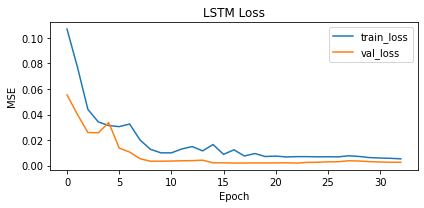

In [9]:
# Loss curves
if history_df is None and HISTORY_PATH.exists():
    history_df = pd.read_csv(HISTORY_PATH)

if history_df is not None and not history_df.empty:
    plt.figure(figsize=(6, 3))
    plt.plot(history_df.get("loss", []), label="train_loss")
    if "val_loss" in history_df:
        plt.plot(history_df["val_loss"], label="val_loss")
    plt.legend()
    plt.title("LSTM Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.tight_layout()
    plt.show()
else:
    print("No training history available to plot.")


In [10]:
# Predictions & metrics
pred = None
if RUN_TRAINING and model is not None:
    yhat_scaled = model.predict(X_test)
    yhat = y_scaler.inverse_transform(yhat_scaled)
    ytrue = y_scaler.inverse_transform(y_test)

    aligned_dates = (
        test_df.iloc[LOOKBACK-1 + (HORIZON-1):]
        .iloc[:len(yhat)]["Date"].reset_index(drop=True)
    )
    pred = pd.DataFrame({
        "Date": aligned_dates,
        "y_true": ytrue.flatten(),
        "y_pred": yhat.flatten(),
    })
    pred_path = PRED_PATH
    pred.to_csv(pred_path, index=False)
    print(f"Saved predictions to {pred_path}")
elif model is not None and TF_AVAILABLE:
    try:
        yhat_scaled = model.predict(X_test)
        yhat = y_scaler.inverse_transform(yhat_scaled)
        ytrue = y_scaler.inverse_transform(y_test)
        aligned_dates = (
            test_df.iloc[LOOKBACK-1 + (HORIZON-1):]
            .iloc[:len(yhat)]["Date"].reset_index(drop=True)
        )
        pred = pd.DataFrame({
            "Date": aligned_dates,
            "y_true": ytrue.flatten(),
            "y_pred": yhat.flatten(),
        })
    except Exception as exc:
        print(f"[warn] Could not generate predictions from loaded model: {exc}")

if pred is None:
    if PRED_PATH.exists():
        pred = pd.read_csv(PRED_PATH, parse_dates=["Date"])
        print(f"Loaded cached predictions from {PRED_PATH}")
    else:
        raise RuntimeError("No predictions available. Enable RUN_TRAINING or provide cached predictions.")

pred = pred.copy()
pred["Date"] = pd.to_datetime(pred["Date"])
pred = pred.sort_values("Date").reset_index(drop=True)
pred["residual"] = pred["y_true"] - pred["y_pred"]
pred["error_pct"] = pred["residual"] / (pred["y_true"] + 1e-9) * 100

naive = pred["y_true"].shift(1).bfill()
metrics_model = {
    "MAE": float(mean_absolute_error(pred["y_true"], pred["y_pred"])),
    "RMSE": float(math.sqrt(mean_squared_error(pred["y_true"], pred["y_pred"]))),
    "MAPE": float(np.mean(np.abs(pred["error_pct"]))),
    "R2": float(r2_score(pred["y_true"], pred["y_pred"])),
}

metrics_baseline = {
    "MAE": float(mean_absolute_error(pred["y_true"], naive)),
    "RMSE": float(math.sqrt(mean_squared_error(pred["y_true"], naive))),
    "MAPE": float(np.mean(np.abs((pred["y_true"] - naive) / (pred["y_true"] + 1e-9)) * 100)),
}

def directional_accuracy(a, f):
    return np.mean(np.sign(np.diff(a, prepend=a.iloc[0])) == np.sign(np.diff(f, prepend=f.iloc[0]))) * 100

metrics_model["DirectionalAcc"] = float(directional_accuracy(pred["y_true"], pred["y_pred"]))
metrics_baseline["DirectionalAcc"] = float(directional_accuracy(pred["y_true"], naive))

metrics_df = pd.DataFrame({
    "LSTM": metrics_model,
    "Naive": metrics_baseline,
})
metrics_df


2025-11-04 10:34:46.043429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-11-04 10:34:46.137766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 9s

2025-11-04 10:34:46.313771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 41ms/step
Saved predictions to experiments/lstm/predictions.csv


,LSTM,Naive
MAE,0.004731,0.003697
RMSE,0.006256,0.005120
MAPE,0.437061,0.340020
R2,0.959104,NaN
DirectionalAcc,52.100840,51.540616


In [11]:
# DM vs Naïve
def diebold_mariano(e1, e2, h=1):
    d = e1 - e2
    dm = np.mean(d)
    dv = np.var(d, ddof=1)
    stat = dm / np.sqrt(dv / len(d) + 1e-12)
    p = 2 * (1 - student_t.cdf(np.abs(stat), df=len(d) - 1))
    return stat, p

se_model = (pred["y_true"] - pred["y_pred"]) ** 2
naive = pred["y_true"].shift(1).bfill()
se_naive = (pred["y_true"] - naive) ** 2
DM, p = diebold_mariano(se_model.values, se_naive.values, h=HORIZON)
{"DM_stat": float(DM), "p_value": float(p)}


{'DM_stat': 4.630275690039375, 'p_value': 5.126050923287551e-06}

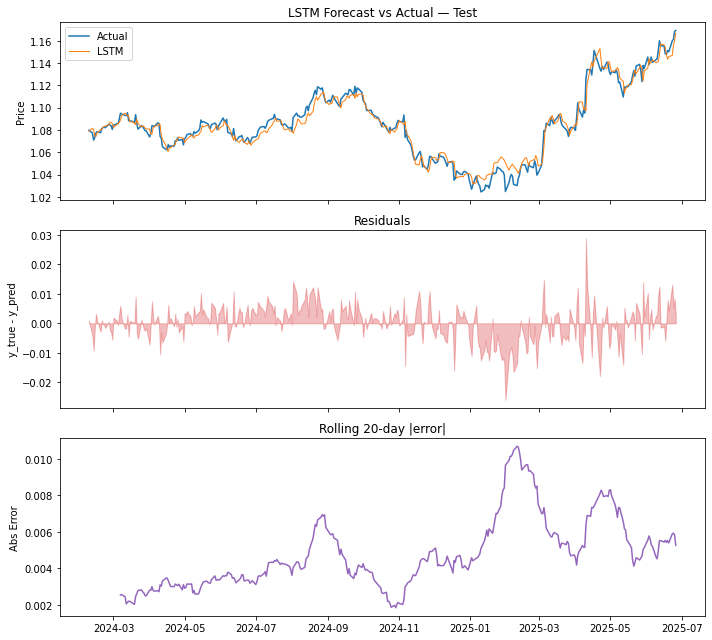

In [12]:
# Diagnostic plots
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
axes[0].plot(pred["Date"], pred["y_true"], label="Actual", linewidth=1.5)
axes[0].plot(pred["Date"], pred["y_pred"], label="LSTM", linewidth=1)
axes[0].set_title("LSTM Forecast vs Actual — Test")
axes[0].set_ylabel("Price")
axes[0].legend()

axes[1].fill_between(pred["Date"], pred["residual"], 0, alpha=0.3, color="tab:red")
axes[1].set_title("Residuals")
axes[1].set_ylabel("y_true - y_pred")

rolling = pred["residual"].abs().rolling(20).mean()
axes[2].plot(pred["Date"], rolling, color="tab:purple")
axes[2].set_title("Rolling 20-day |error|")
axes[2].set_ylabel("Abs Error")
axes[2].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()


In [13]:
# Simple Sharpe (directional strategy)
rets = pred["y_true"].pct_change().fillna(0.0)
signal = np.sign(pred["y_pred"].diff().fillna(0.0))
strat = signal.shift(1).fillna(0.0) * rets
sharpe = (strat.mean() / strat.std() * np.sqrt(252)) if strat.std() > 0 else 0.0
sharpe


0.37454538869875686

Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[warn] DeepExplainer failed (in user code:

    File "/Users/sringtho/miniforge3/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 245, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/Users/sringtho/miniforge3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/sringtho/miniforge3/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 394, in custom_grad
        out = op_handlers[type_name](self, op, *grads)  # we cut off the shap_ prefix before the lookup
    File "/Users/sringtho/miniforge3/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 691, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "/Users/sringtho/miniforge3/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 700, in linearity_with_excluded_handler
        assert not explainer._vari

  0%|          | 0/128 [00:00<?, ?it/s]

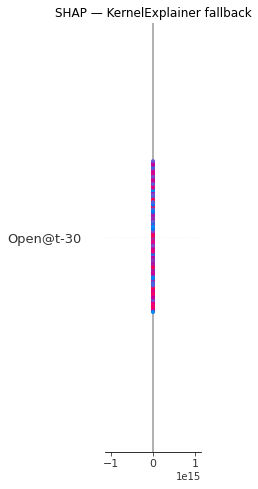

No SHAP-based feature importance available.


In [14]:
# SHAP (optional, only when TensorFlow + model available)
importance_df = None
importance_path = Path(OUT_DIR) / "feature_importance.csv"

if TF_AVAILABLE and model is not None and RUN_TRAINING:
    import shap
    shap_summary_sample = min(128, len(X_test))
    if shap_summary_sample == 0:
        print("[warn] SHAP skipped: no test samples available.")
    else:
        bg_idx = np.random.choice(len(X_train), size=min(256, len(X_train)), replace=False)
        background = X_train[bg_idx]
        feature_labels = [str(feat) for feat in FEATURES]

        shap_tensor = None
        try:
            deep_explainer = shap.DeepExplainer(model, background)
            shap_values = deep_explainer.shap_values(X_test[:shap_summary_sample])
            values_to_plot = shap_values[0] if isinstance(shap_values, list) else shap_values
            shap.summary_plot(
                values_to_plot,
                features=X_test[:shap_summary_sample],
                feature_names=feature_labels,
                show=False,
            )
            plt.title("SHAP — DeepExplainer")
            plt.show()
            shap_tensor = values_to_plot
        except Exception as exc:
            print(f"[warn] DeepExplainer failed ({exc}). Falling back to KernelExplainer.")
            try:
                flat_features = LOOKBACK * len(FEATURES)
                background_flat = background.reshape(background.shape[0], flat_features)
                eval_data_flat = X_test[:shap_summary_sample].reshape(shap_summary_sample, flat_features)

                time_steps = list(range(LOOKBACK))
                flat_labels = [
                    f"{feat}@t-{LOOKBACK - step}"
                    for step in time_steps
                    for feat in FEATURES
                ]

                def predict_fn(xflat):
                    x = xflat.reshape((-1, LOOKBACK, len(FEATURES)))
                    return model.predict(x, verbose=0)

                kernel_explainer = shap.KernelExplainer(predict_fn, background_flat)
                shap_values_flat = kernel_explainer.shap_values(eval_data_flat, nsamples=100)
                values_to_plot = shap_values_flat[0] if isinstance(shap_values_flat, list) else shap_values_flat
                shap.summary_plot(
                    values_to_plot,
                    features=eval_data_flat,
                    feature_names=flat_labels,
                    show=False,
                )
                plt.title("SHAP — KernelExplainer fallback")
                plt.show()
                if values_to_plot.ndim == 2 and values_to_plot.shape[1] == flat_features:
                    shap_tensor = values_to_plot.reshape(shap_summary_sample, LOOKBACK, len(FEATURES))
            except Exception as inner_exc:
                print(f"[warn] KernelExplainer failed: {inner_exc}. SHAP skipped.")

        if shap_tensor is not None:
            if shap_tensor.ndim == 3 and shap_tensor.shape[-1] == len(FEATURES):
                mean_abs = np.mean(np.abs(shap_tensor), axis=(0, 1))
                importance_df = pd.DataFrame({
                    "feature": FEATURES,
                    "importance": mean_abs,
                }).sort_values("importance", ascending=False)
            elif shap_tensor.ndim == 2 and shap_tensor.shape[1] == len(FEATURES):
                mean_abs = np.mean(np.abs(shap_tensor), axis=0)
                importance_df = pd.DataFrame({
                    "feature": FEATURES,
                    "importance": mean_abs,
                }).sort_values("importance", ascending=False)
            else:
                print("[warn] Could not aggregate SHAP tensor; unexpected shape.")
else:
    print("SHAP explanation skipped (model unavailable or training disabled).")

if importance_df is None and importance_path.exists():
    importance_df = pd.read_csv(importance_path)
    print(f"Loaded cached SHAP importance from {importance_path}")

if importance_df is not None and not importance_df.empty:
    plt.figure(figsize=(6, 4))
    plt.barh(importance_df["feature"], importance_df["importance"], color="tab:blue")
    plt.gca().invert_yaxis()
    plt.title("LSTM Feature Importance (|SHAP| mean)")
    plt.xlabel("Mean |SHAP|")
    plt.tight_layout()
    plt.show()
    importance_df.to_csv(importance_path, index=False)
    print(f"Saved feature importances to {importance_path}")
else:
    print("No SHAP-based feature importance available.")


In [15]:
# Save report
report = {
    "symbol": SYMBOL,
    "rows": int(len(df)),
    "lookback": LOOKBACK,
    "horizon": HORIZON,
    "metrics": metrics_model,
    "baseline": metrics_baseline,
    "dm_test_vs_naive": {"DM": float(DM), "p": float(p)},
    "sharpe": float(sharpe),
    "predictions_csv": str(PRED_PATH),
    "history_csv": str(HISTORY_PATH) if HISTORY_PATH.exists() else None,
    "tests": {
        "predictions_available": bool(len(pred) > 0),
        "rmse_better_than_naive": bool(metrics_model["RMSE"] <= metrics_baseline["RMSE"] * 1.05),
    },
}
report_path = Path(OUT_DIR) / "report.json"
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)
report


{'symbol': 'EURUSD=X',
 'rows': 5295,
 'lookback': 30,
 'horizon': 1,
 'metrics': {'MAE': 0.004731084452289831,
  'RMSE': 0.006255894082178711,
  'MAPE': 0.4370610644200538,
  'R2': 0.9591044494807954,
  'DirectionalAcc': 52.10084033613446},
 'baseline': {'MAE': 0.003696508100386756,
  'RMSE': 0.0051201987382222,
  'MAPE': 0.34001954603696727,
  'DirectionalAcc': 51.540616246498594},
 'dm_test_vs_naive': {'DM': 4.630275690039375, 'p': 5.126050923287551e-06},
 'sharpe': 0.37454538869875686,
 'predictions_csv': 'experiments/lstm/predictions.csv',
 'history_csv': 'experiments/lstm/history.csv',
 'tests': {'predictions_available': True, 'rmse_better_than_naive': False}}